# Problem 1



In [68]:
# Imports

import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import time
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN

# Load data
mat_file = loadmat('../sample_1.mat')


# Plotting Sample 1
## Interactive plot of the complete first sample
Interactive plot. You can zoom in and scroll along both axes. 

In [43]:
%matplotlib notebook

data = mat_file['data'][0]
plt.plot(data)

plt.show()

## Subplots of the first 10000 data points in sample 1
The first 10000 data points and the ground truth in a series of subplots. The axes are scaled so that we can observe what the spikes look like. The red lines parallel to the x axis mark the spike times of spikes in the data set. This is the ground truth. 

We can already observe that there seems to be an offset between the local maximum of a spike and the spike time. The most intuitive explanation for this is that the data set contains the times when a spike was induced through some trigger. As the system is slow the potential of the neurons rises slower and is detectable in form of a local maximum a few timesteps after the spike was induced. 

We will need to take this into account when detecting the spikes. 

<IPython.core.display.Javascript object>

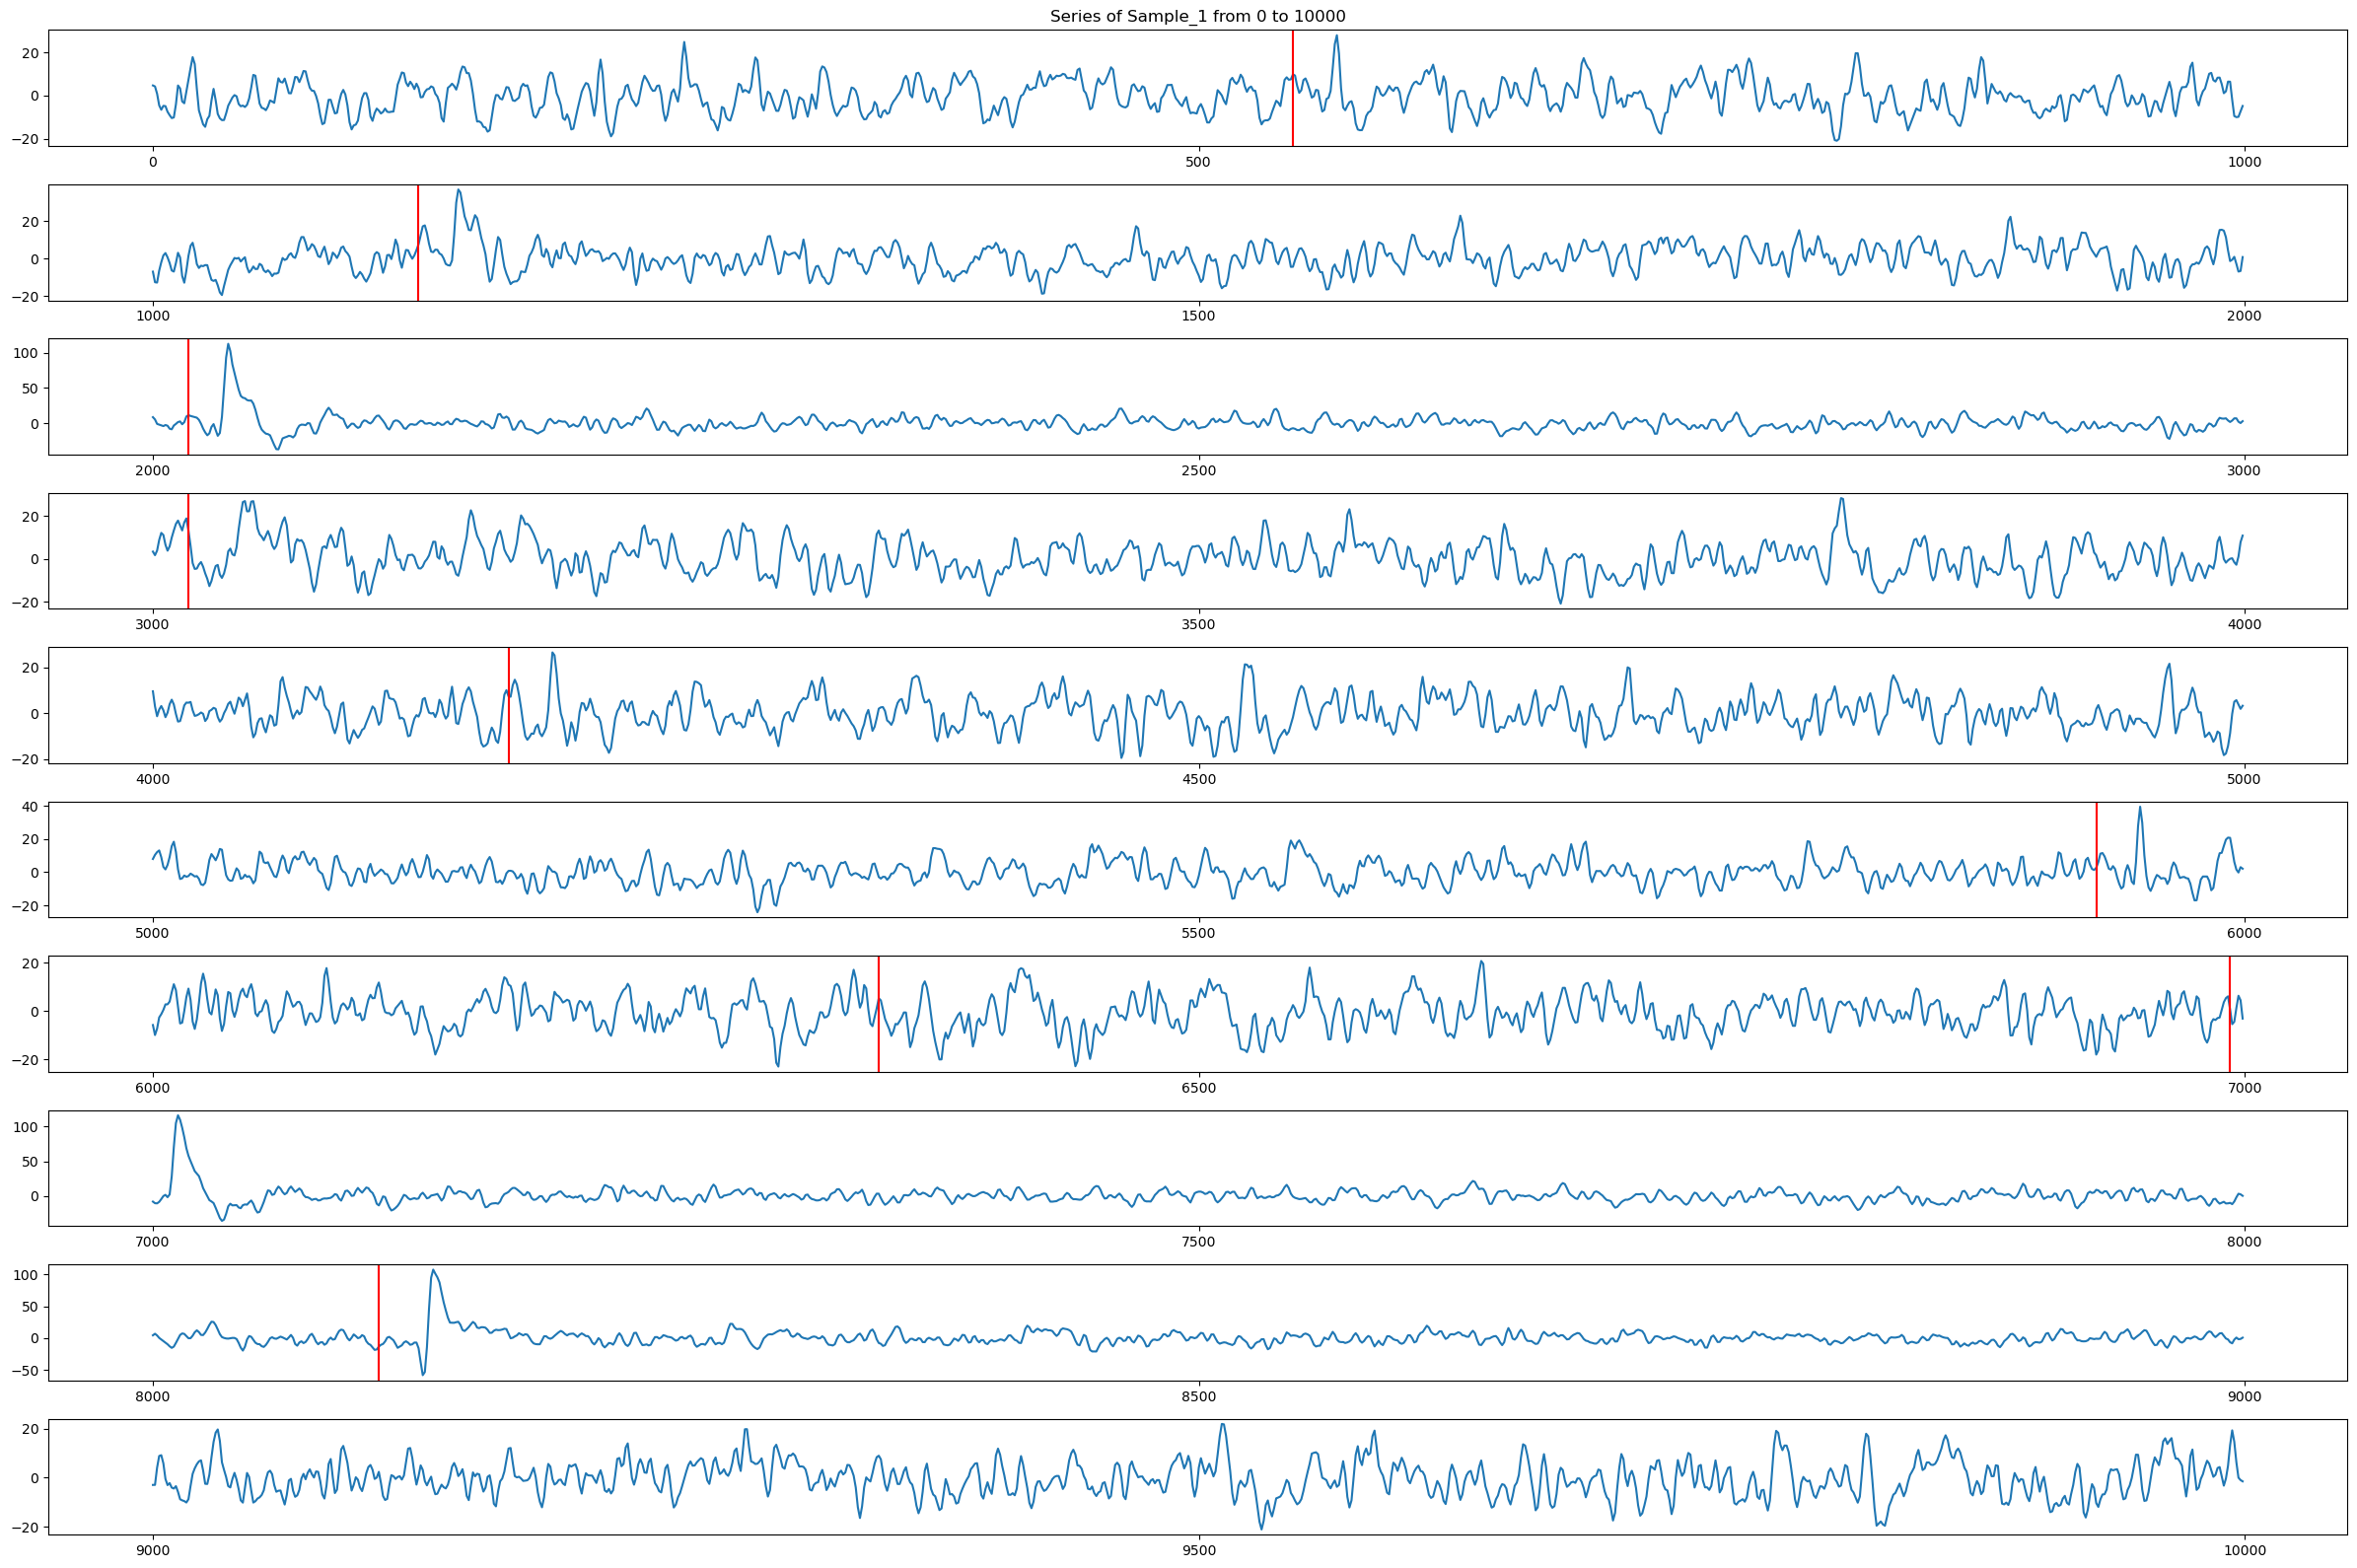

In [44]:
%matplotlib inline
data = mat_file['data'][0][:10000]
spike_times = mat_file['spike_times'][0][0][0]

# TODO: Add labels

SUBPLOT_SIZE = 1000
N_SUBPLOTS = data.shape[0]//SUBPLOT_SIZE

fig, ax = plt.subplots(nrows=N_SUBPLOTS, ncols=1, figsize=(24,16))


for i in range(0, N_SUBPLOTS):
    start = i*SUBPLOT_SIZE
    end = (i+1)*SUBPLOT_SIZE

    ax[i].plot(data[start:end])
    ax[i].set_xticks([0, SUBPLOT_SIZE // 2, SUBPLOT_SIZE])
    ax[i].set_xticklabels([start, (start + end) // 2, end])
    
    for j, truth in enumerate(spike_times):
        if start < truth <= end:
            ax[i].axvline(truth-start, color='red', label="ground truth")
    

ax[0].set_title("Series of Sample_1 from 0 to 10000")
plt.tight_layout()
# plt.savefig('figures/data_sample_1.pdf')
plt.show() 
    

## Spikes by Classes
The spikes are grouped into different classes according to their properties. Below are plots for each class to get a better understanding of what those properties are. 

In [45]:
def plot_clusters_by_class(class_label):
    data = mat_file['data'][0]
    classes = mat_file['spike_class'][0][0][0]
    spike_times = mat_file['spike_times'][0][0][0]
    
    spikes = spike_times[np.where(classes==class_label)]
    
    fig, ax = plt.subplots(nrows=6, ncols=3, figsize=(24,16))
    
    for i in range(18):

        ax[i//3][i%3].plot(data[spikes[i]-50:spikes[i]+50])
        
    ax[0][1].set_title(f'Spikes of Class {class_label}')
    plt.tight_layout()
    # plt.savefig(f'figures/spike_class_{class_label}_plot.pdf')
    plt.show()

# for debugging
# plot_clusters_by_class(2)

print("Classes in the sample are:")
classes = mat_file['spike_class'][0][0][0]
print(np.unique(classes))

Classes in the sample are:
[0 1 2]


### Class 0

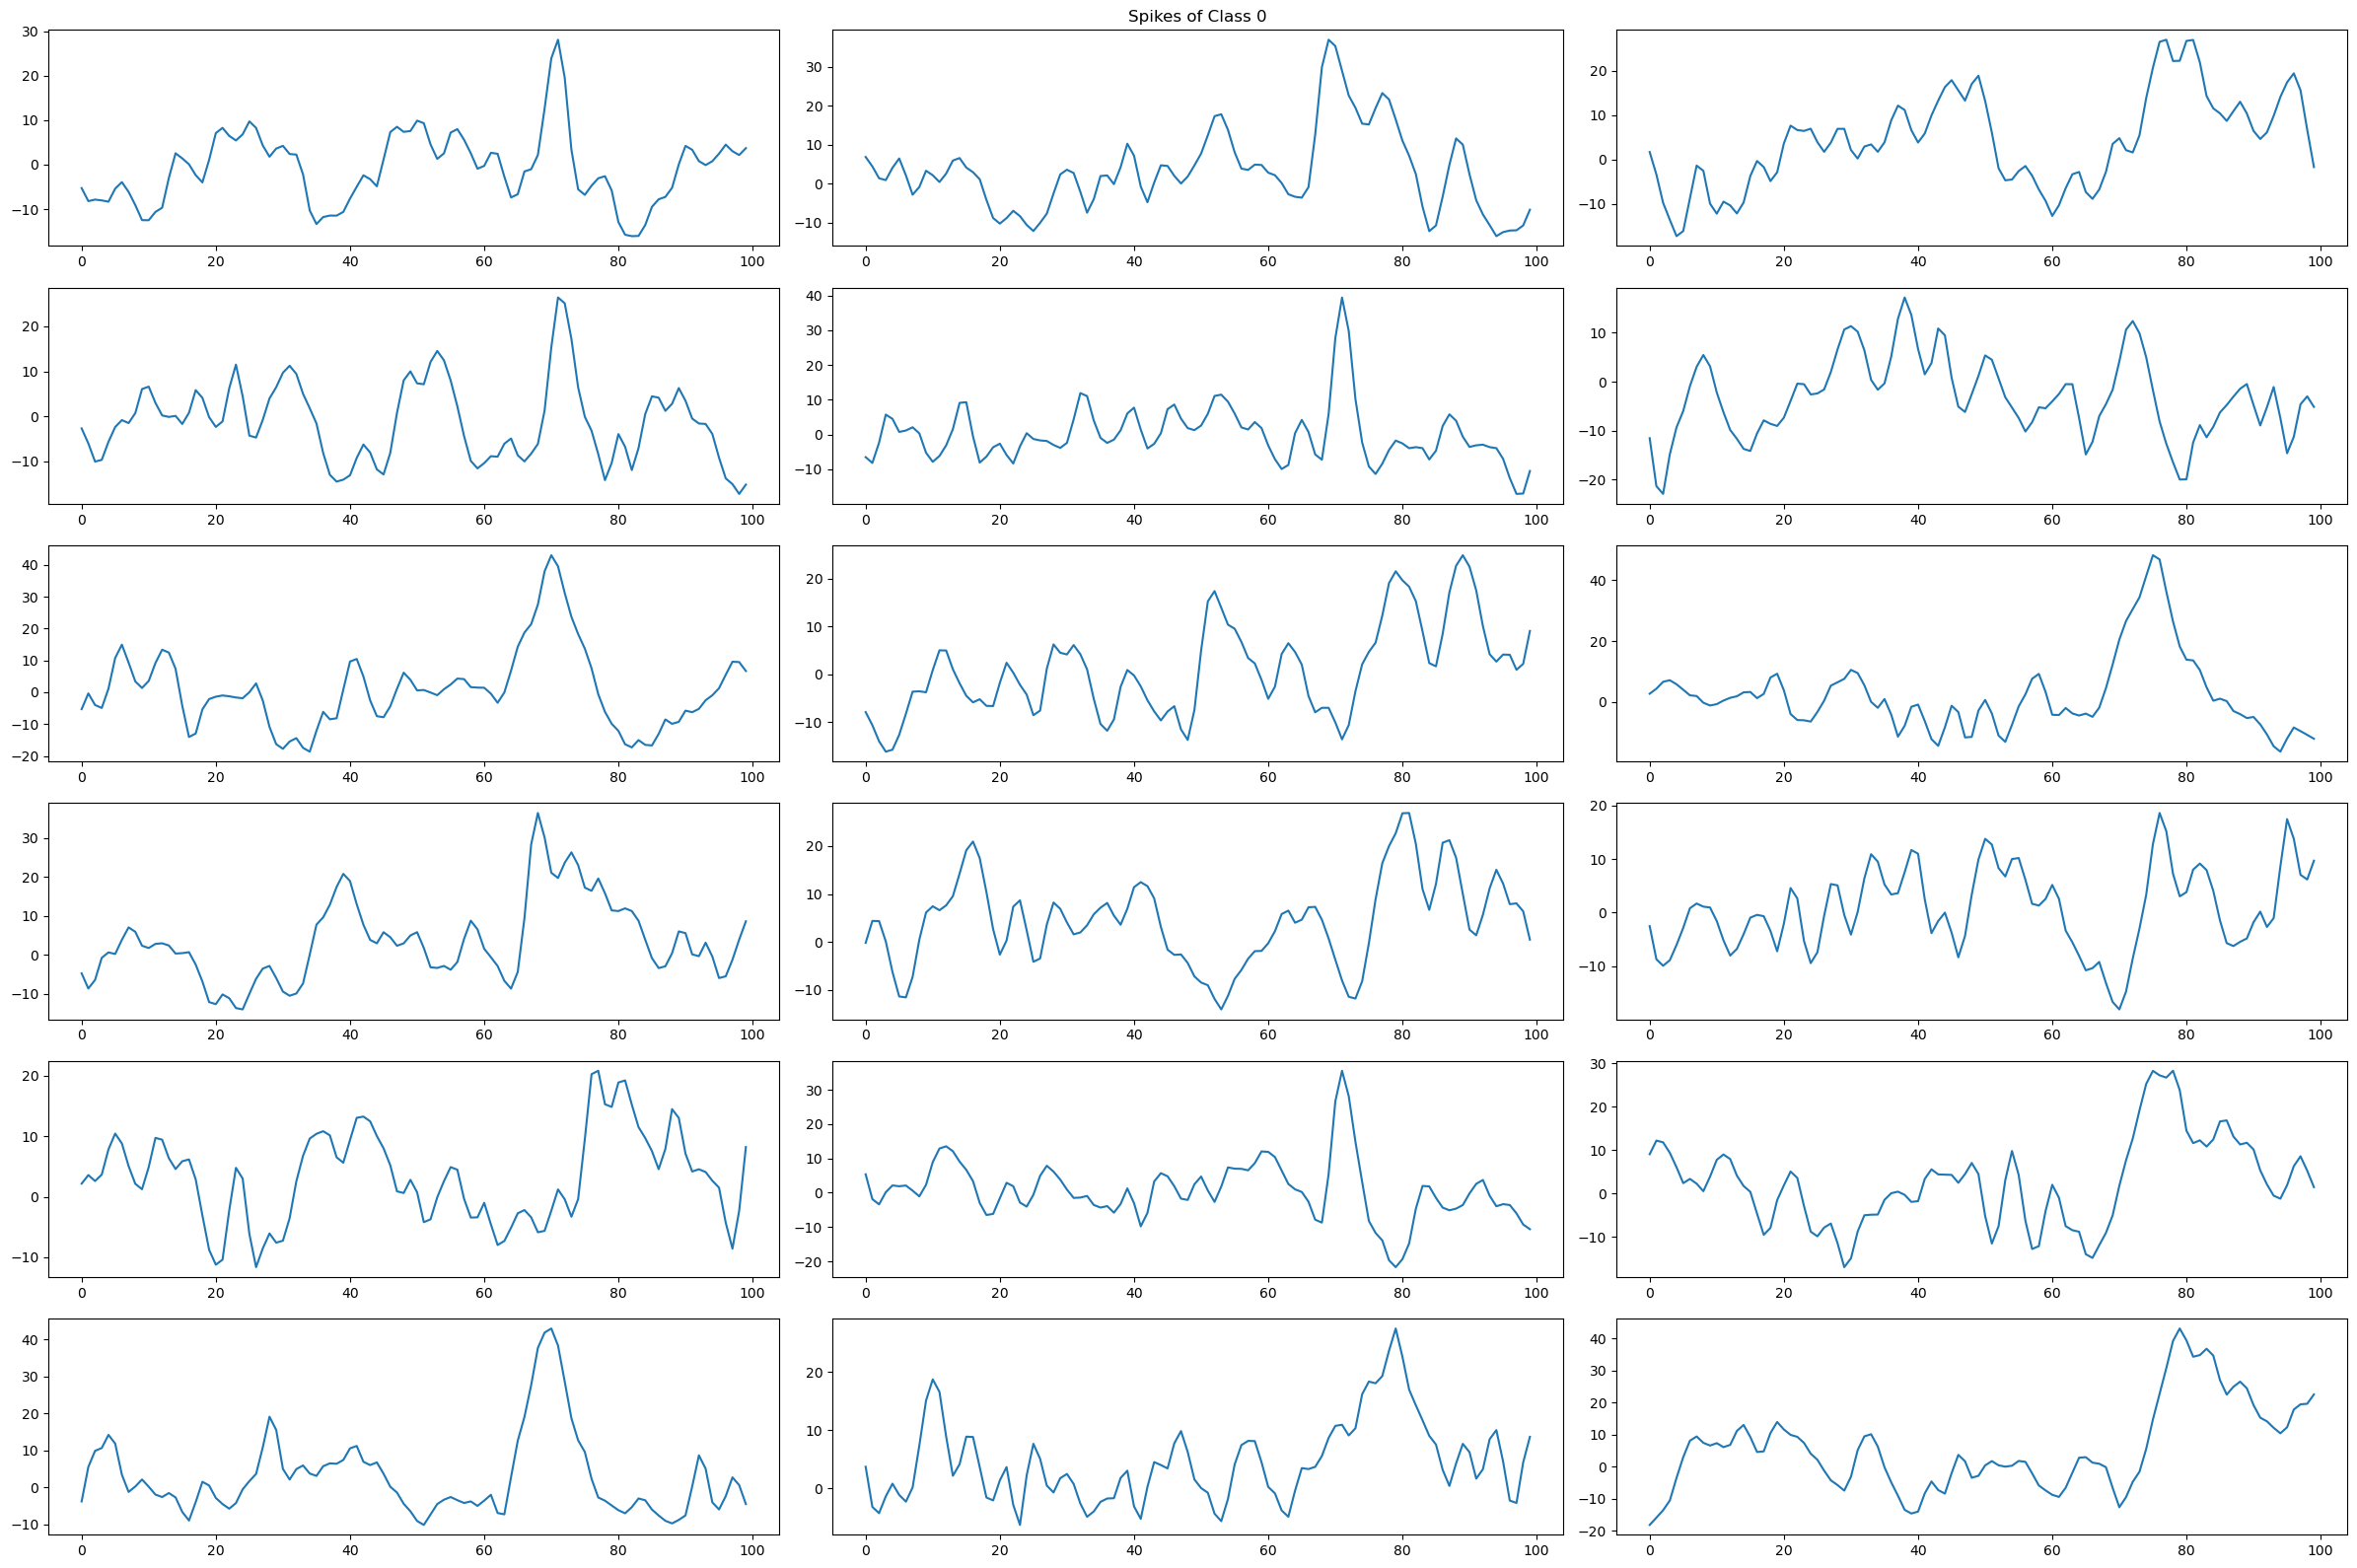

In [46]:
plot_clusters_by_class(0)

### Class 1

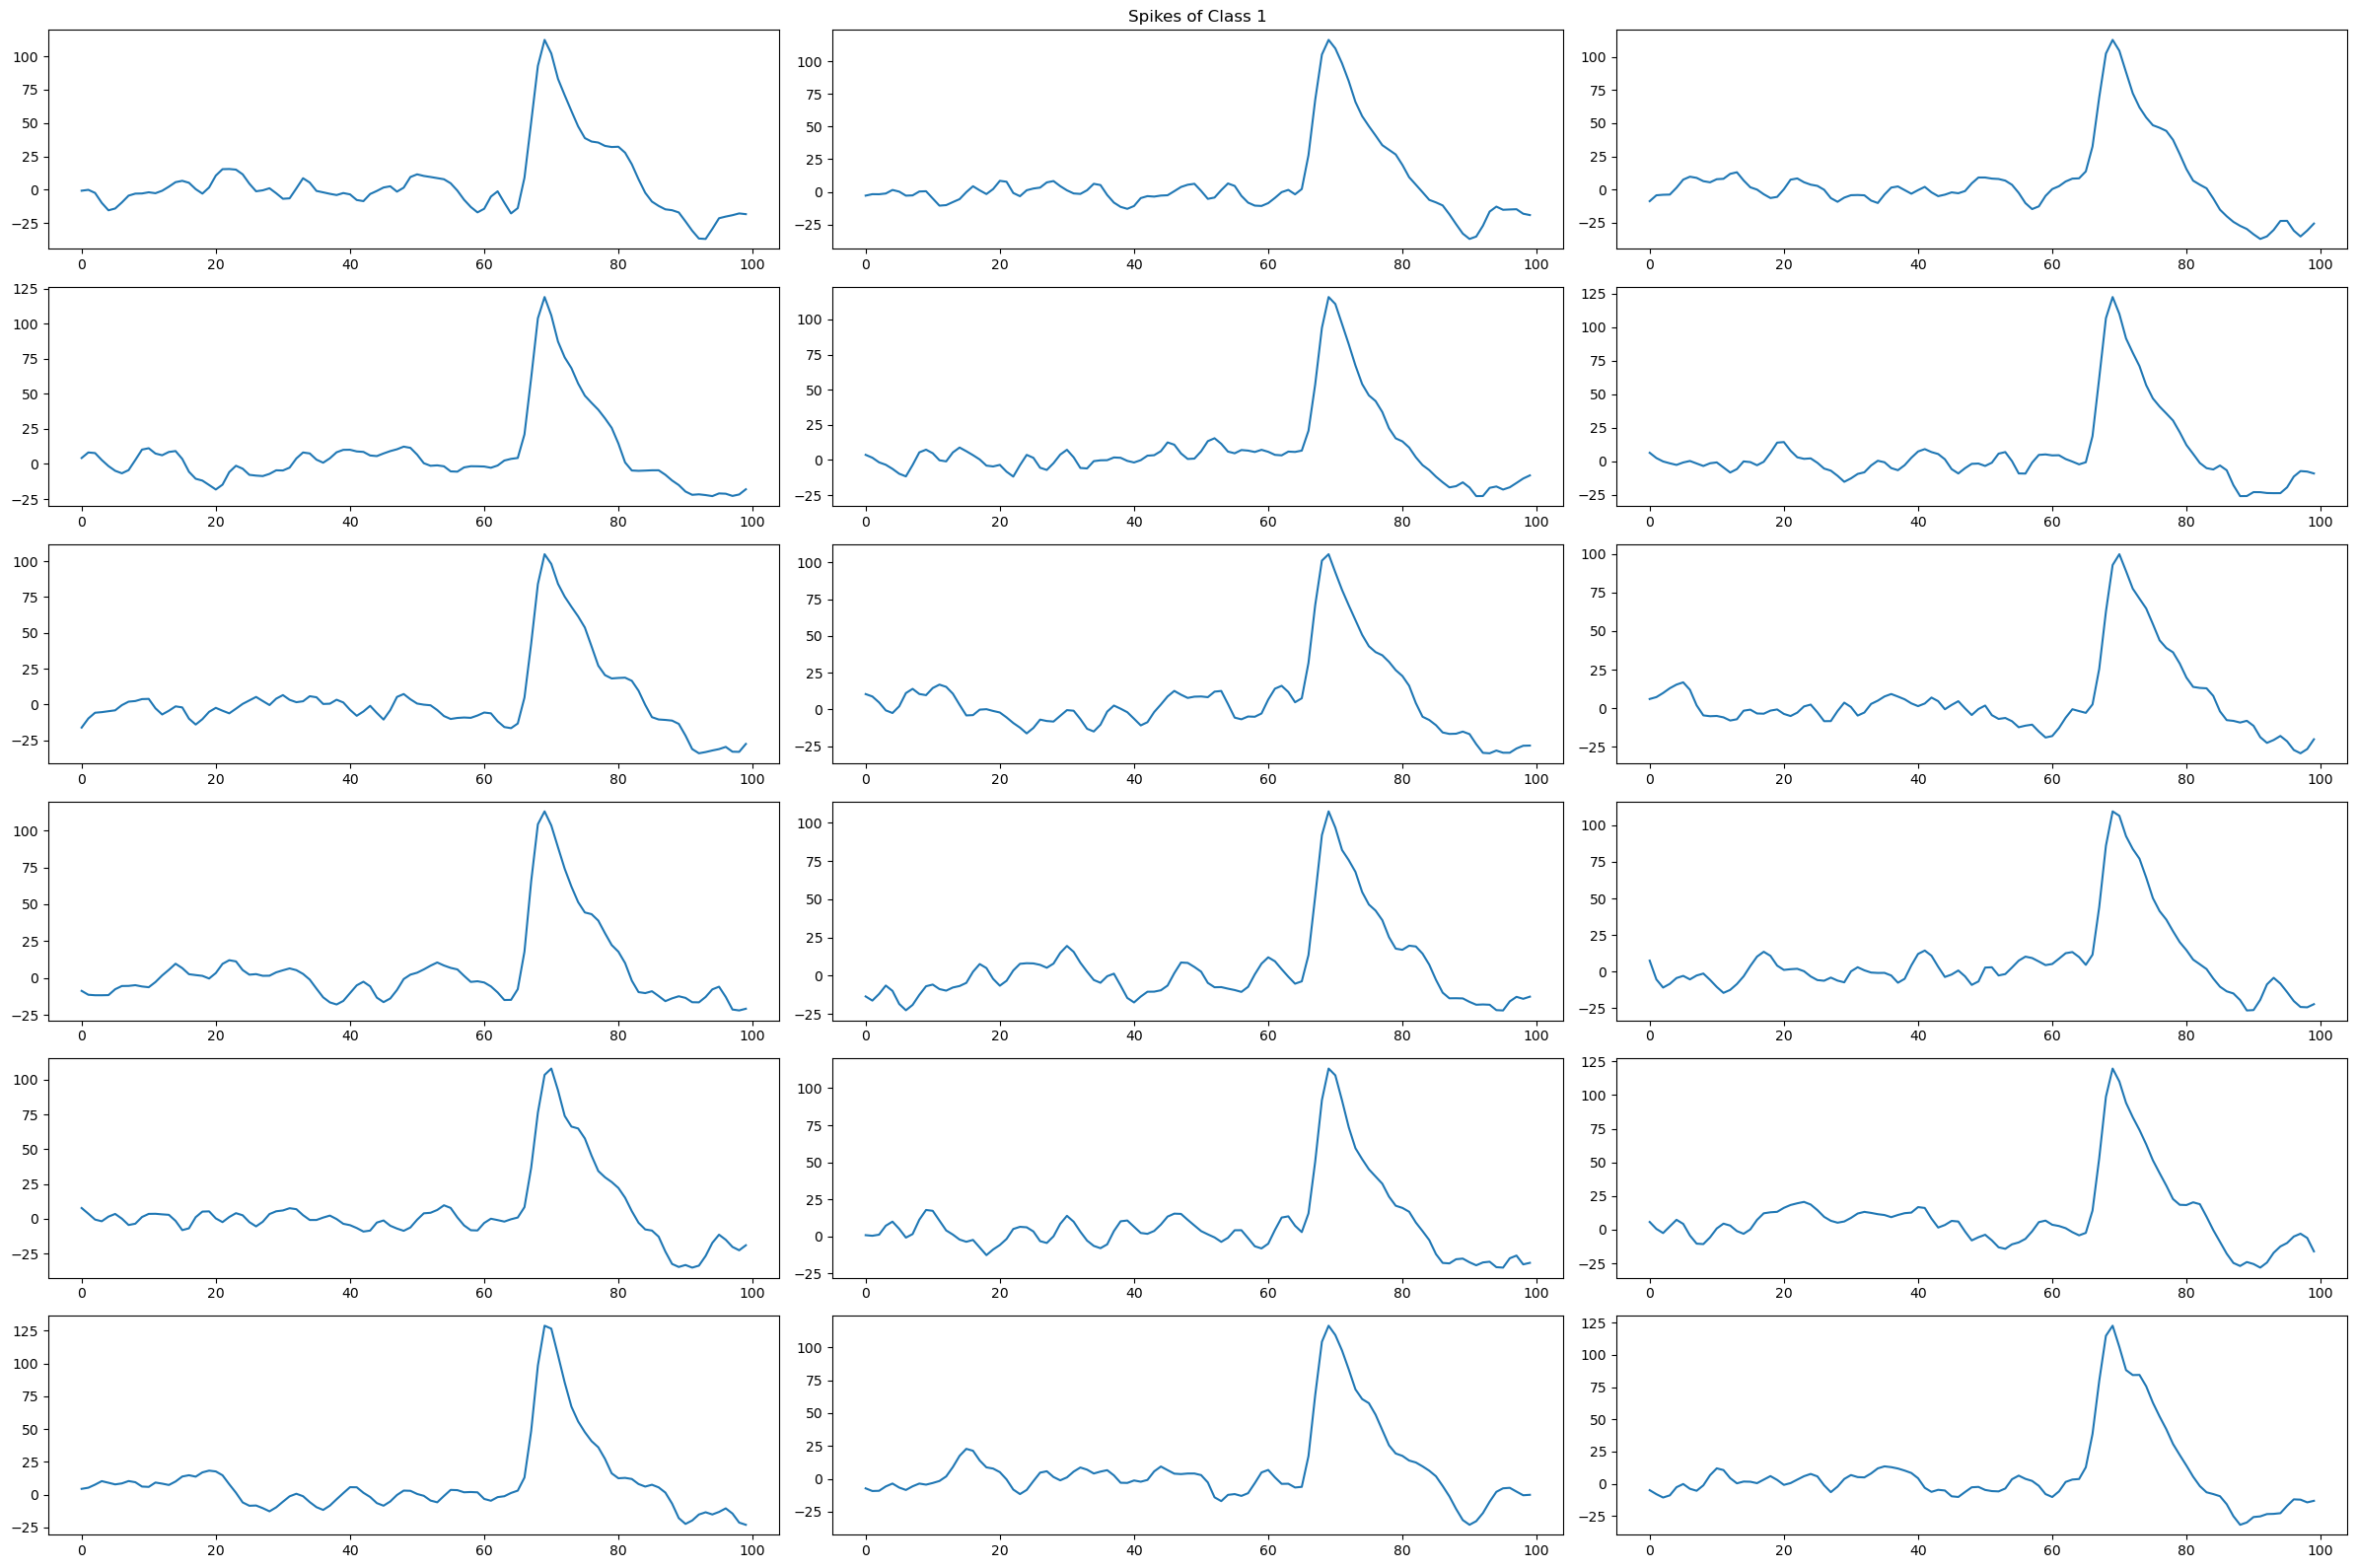

In [47]:
plot_clusters_by_class(1)

### Class 2

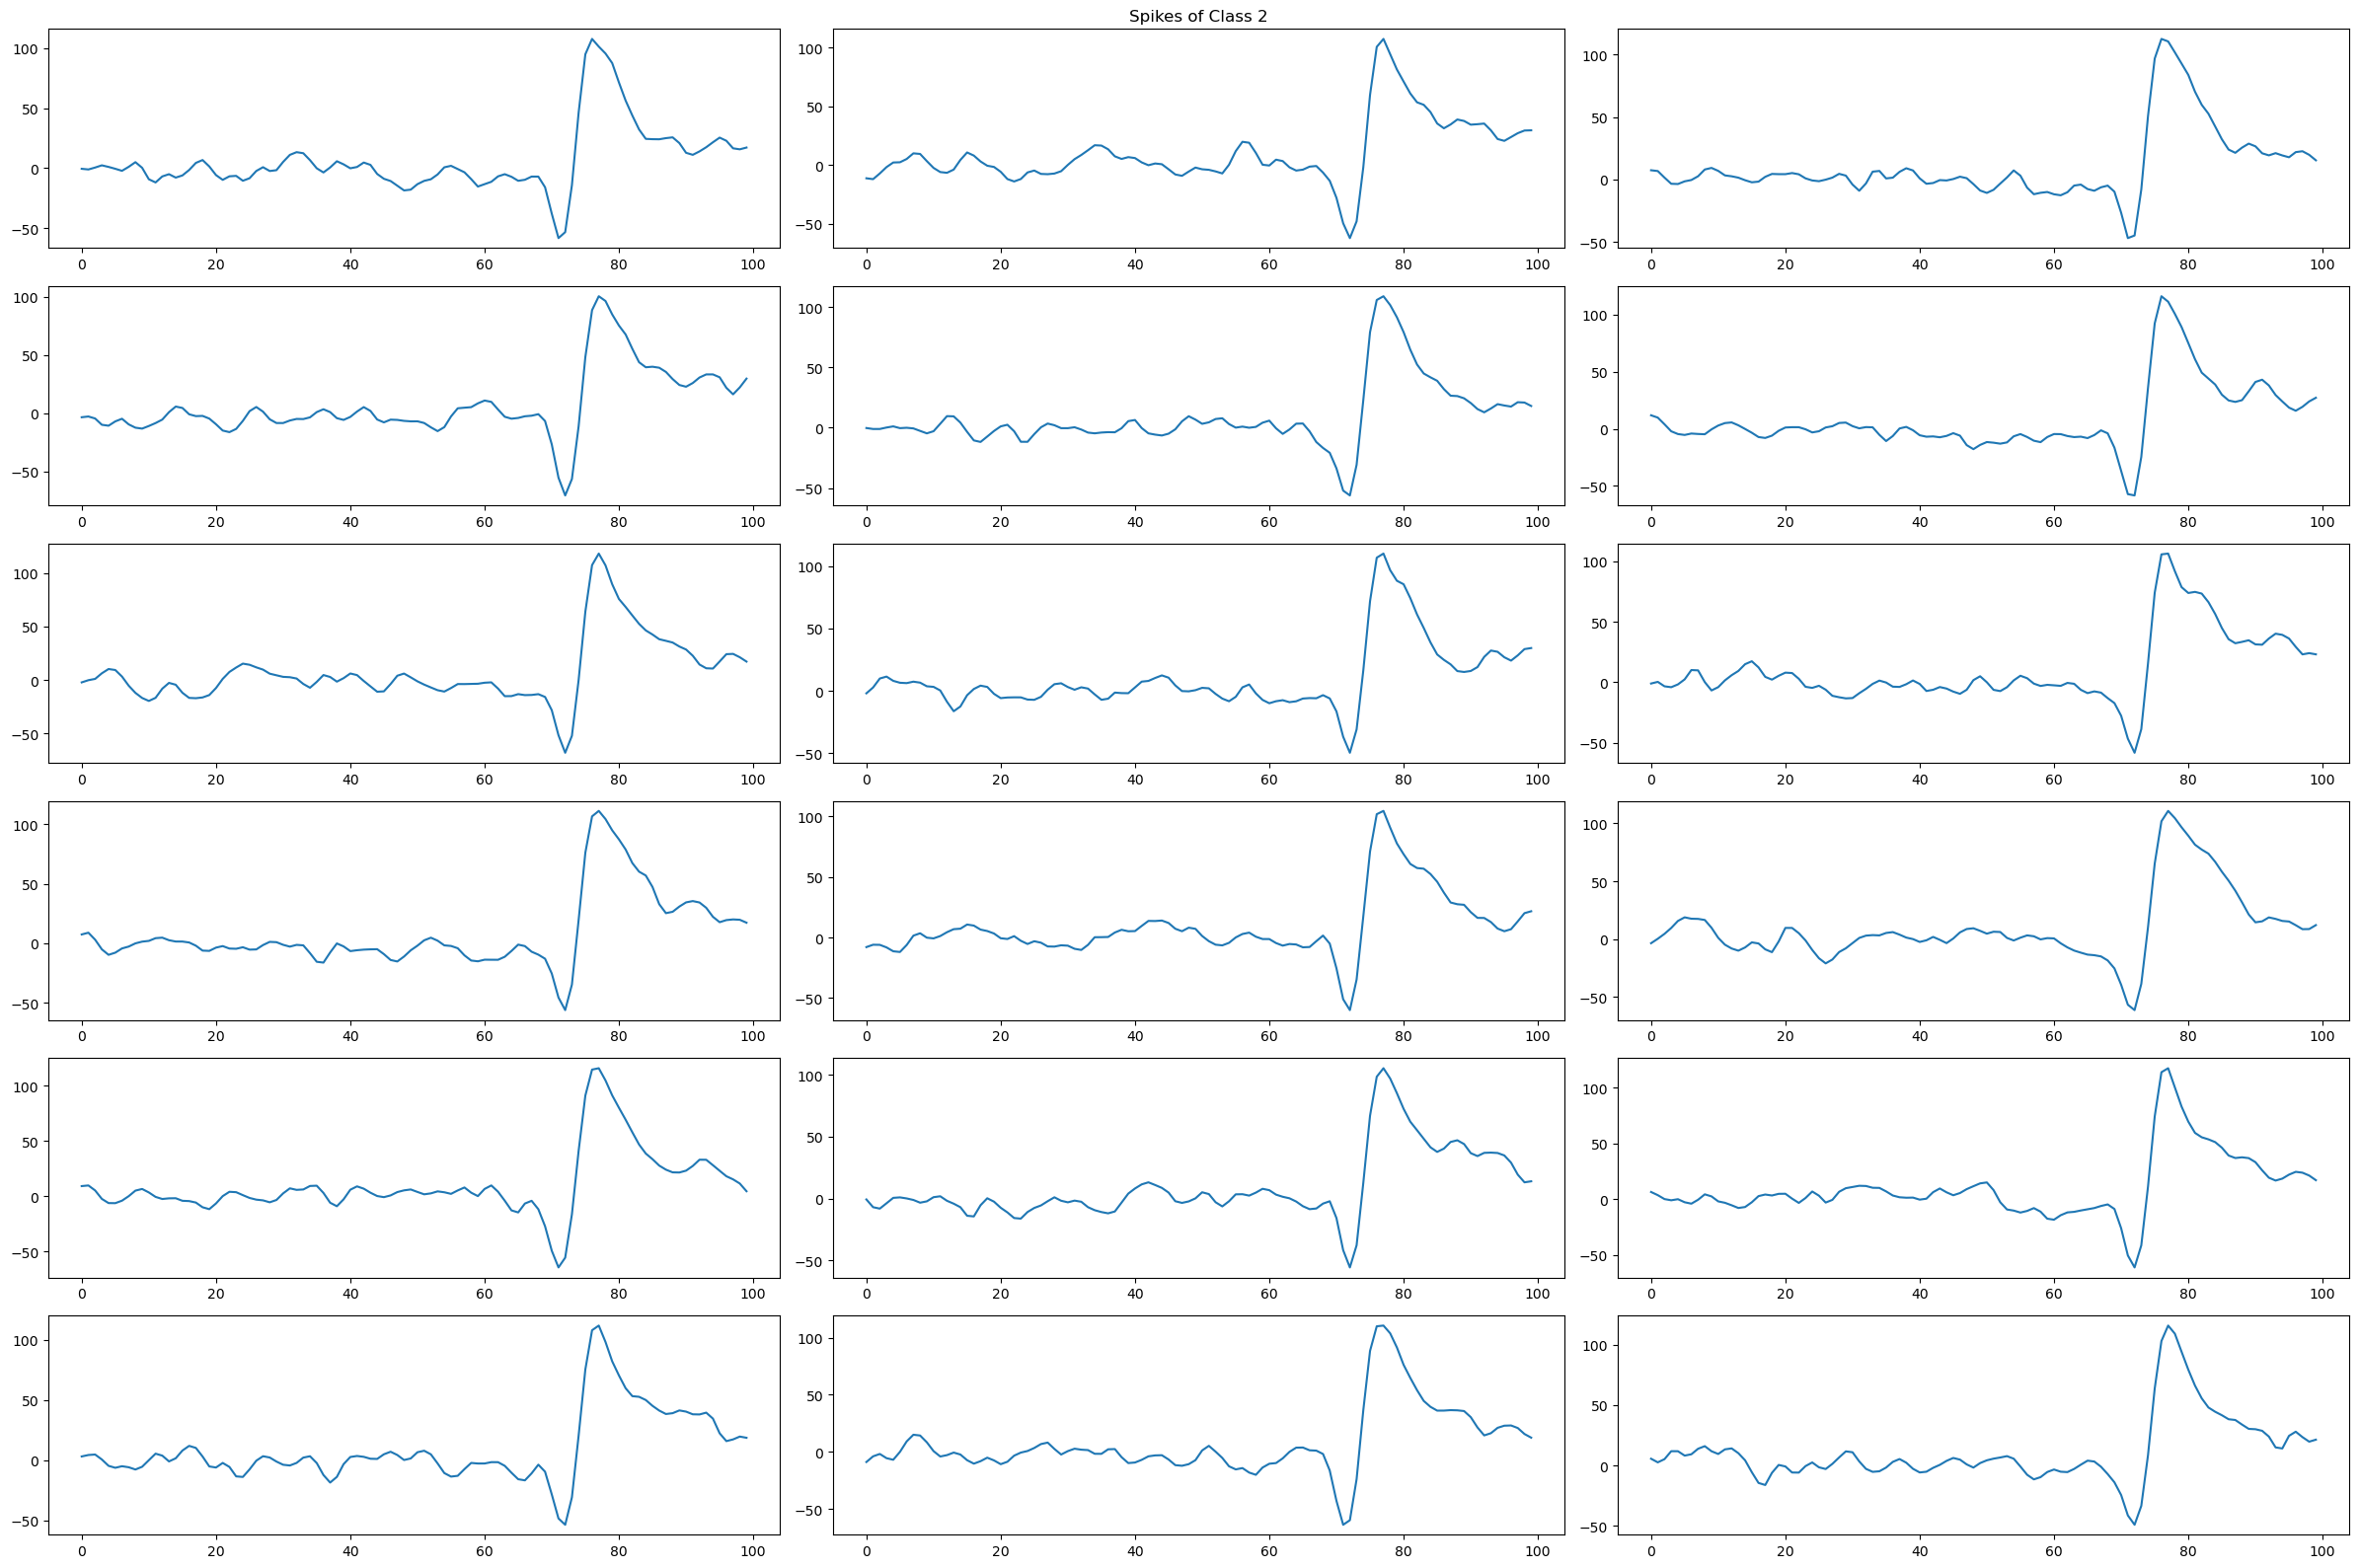

In [48]:
plot_clusters_by_class(2)

# Finding Spikes in the Data
First, we introduce metrics used to evaluate our approach. We will rely on precision and recall in the first step as they account for the number of false positve and false negative predictions that occur. 

If we consider the interval part of our learnable parameters then it might also make sense to introduce the metric "Intersect over Union" As this accounts for the total are of the intervals that match. 


In [49]:

def count_fn_fp(ground_truth, predictions, tolerance=40):
    """
    Count the number of false positives, false negatives, and true positives.
    
    Parameters:
    - ground_truth (numpy array): Ground truth spike times.
    - predictions (numpy array): Predicted spike times.
    - tolerance (int): Tolerance window in points for matching a prediction to ground truth.
    
    Returns:
    - false_negative (int): Number of false negatives.
    - false_positive (int): Number of false positives.
    - true_positive (int): Number of true positives.
    """
    
    matched_spikes = set()
    true_positive_spikes = set()
    
    update_interval = 1000
    start_time = time.time()

    # Loop over each ground truth spike
    for idx, d in enumerate(ground_truth):
        found_match = False
        for p in predictions:
            if d - tolerance/5 <= p <= d + 4*tolerance/5:
                # True positive found
                matched_spikes.add(d)
                true_positive_spikes.add(p)
                found_match = True
                break  # Move to the next ground truth spike once a match is found

        # Log progress
        if idx % update_interval == 0:
            print(f"Checking accuracy: {idx // update_interval} of {len(ground_truth) // update_interval} in {time.time() - start_time:.2f} seconds")
            start_time = time.time()

    # Calculate counts
    false_negative = len(ground_truth) - len(matched_spikes)
    false_positive = len(predictions) - len(true_positive_spikes)
    true_positive = len(true_positive_spikes)
    
    print(f"False Negatives: {false_negative}, False Positives: {false_positive}, True Positives: {true_positive}")
    
    return false_negative, false_positive, true_positive

def fast_count_fp_fn_tp(ground_truth, predictions, tolerance=40):
    predictions = np.sort(predictions)  # Ensure sorted for easier traversal
    ground_truth = np.sort(ground_truth)
    
    tp, fp, fn = 0, 0, 0
    i, j = 0, 0

    while i < len(predictions) and j < len(ground_truth):
        if abs(predictions[i] - ground_truth[j]) <= tolerance:
            # True Positive: Match found within the window range
            tp += 1
            i += 1
            j += 1
        elif predictions[i] < ground_truth[j]:
            # False Positive: Prediction with no matching ground truth within window
            fp += 1
            i += 1
        else:
            # False Negative: Ground truth with no matching prediction within window
            fn += 1
            j += 1

    # Remaining unmatched predictions and ground truths
    fp += len(predictions) - i
    fn += len(ground_truth) - j

    return fp, fn, tp
            

def calc_precision(tp, fp):
    try:
        return tp / (tp + fp)
    except ZeroDivisionError:
        return -1

def calc_recall(tp, fn):
    try:
        return tp / (tp + fn)
    except ZeroDivisionError:
        return -1

def calc_F1_score(tp, fp, fn):
    try:
        prec = calc_precision(tp, fp)
        rec = calc_recall(tp, fn)
        return 2 * (prec * rec) / (prec + rec)
    except ZeroDivisionError:
        return -1
    
    

# Debugging

# params
interval_param = 25
threshold_param = 2.7

# data
data = mat_file['data'][0]
spike_times = mat_file['spike_times'][0][0][0]


# mean and stdv
mean = np.mean(data, axis=0)
std_dev = np.std(data, axis=0)


threshold = mean + threshold_param * std_dev

detected_spikes = np.where((data > threshold).astype(int) == 1)[0]

fn, fp, tp = fast_count_fp_fn_tp(spike_times, detected_spikes)

print(f'false positives: {fn}, false negatives: {fp}, true positives: {tp}')

false positives: 21767, false negatives: 686, true positives: 2528


## Without Z-Score 
In the first step I am setting a threshold based on the mean and the standard deviation of the data. 

In [50]:
# params
threshold_param = 2.7

# data
data = mat_file['data'][0]
spike_times = mat_file['spike_times'][0][0][0]


# mean and stdv
mean = np.mean(data, axis=0)
std_dev = np.std(data, axis=0)


threshold = mean + threshold_param * std_dev

For every data point I compare two consequitive data points with a threshold. If the first value was below the threshold and the second is above we detect this as a spike. 

In [51]:
data = mat_file['data'][0]

# for i in range(data.shape[0]-1):
#     if data[i] < threshold and data[i+1] >= threshold:
#         detected_spikes.append(i)
def detect_spikes(data, threshold):
    return np.where((data > threshold).astype(int) == 1)[0]

detected_spikes = detect_spikes(data, threshold)
print(detected_spikes)
# detected_spikes = np.array(detected_spikes).reshape(-1,)

# plt.plot(data[0:1000])
# 
# 
# plt.axvline(spike_times[np.where(spike_times<1000)], color='red', label="ground truth")
# 
# # plt.axvline(detected_spikes[np.where(detected_spikes<1000)], color='red', label="ground truth")
# for detected in detected_spikes:
#     if detected < 1000:
#         plt.axvline(detected, color='green', label="detected")
# 
# plt.legend()
# plt.show()

ground_truth = mat_file['spike_times'][0][0][0]

fp, fn, tp = fast_count_fp_fn_tp(ground_truth, detected_spikes)

print(f"There where {tp} spikes detected correctly out of {fn+tp}. [fn = {fn}, tp = {tp}, fp = {fp}]")
precision = calc_precision(tp, fp)
recall = calc_recall(tp, fn)
F1_score = calc_F1_score(tp, fp, fn)
print(f"Precision: {precision}, Recall: {recall}, F1: {F1_score}")

[    566    1145    1146 ... 2879621 2879623 2879624]
There where 2528 spikes detected correctly out of 3214. [fn = 686, tp = 2528, fp = 21767]
Precision: 0.10405433216711257, Recall: 0.7865588052271313, F1: 0.1837943945617798


Let's create some plots of what we detected. We will mark the detected spikes with a green line and the groundtruth with red as before. 

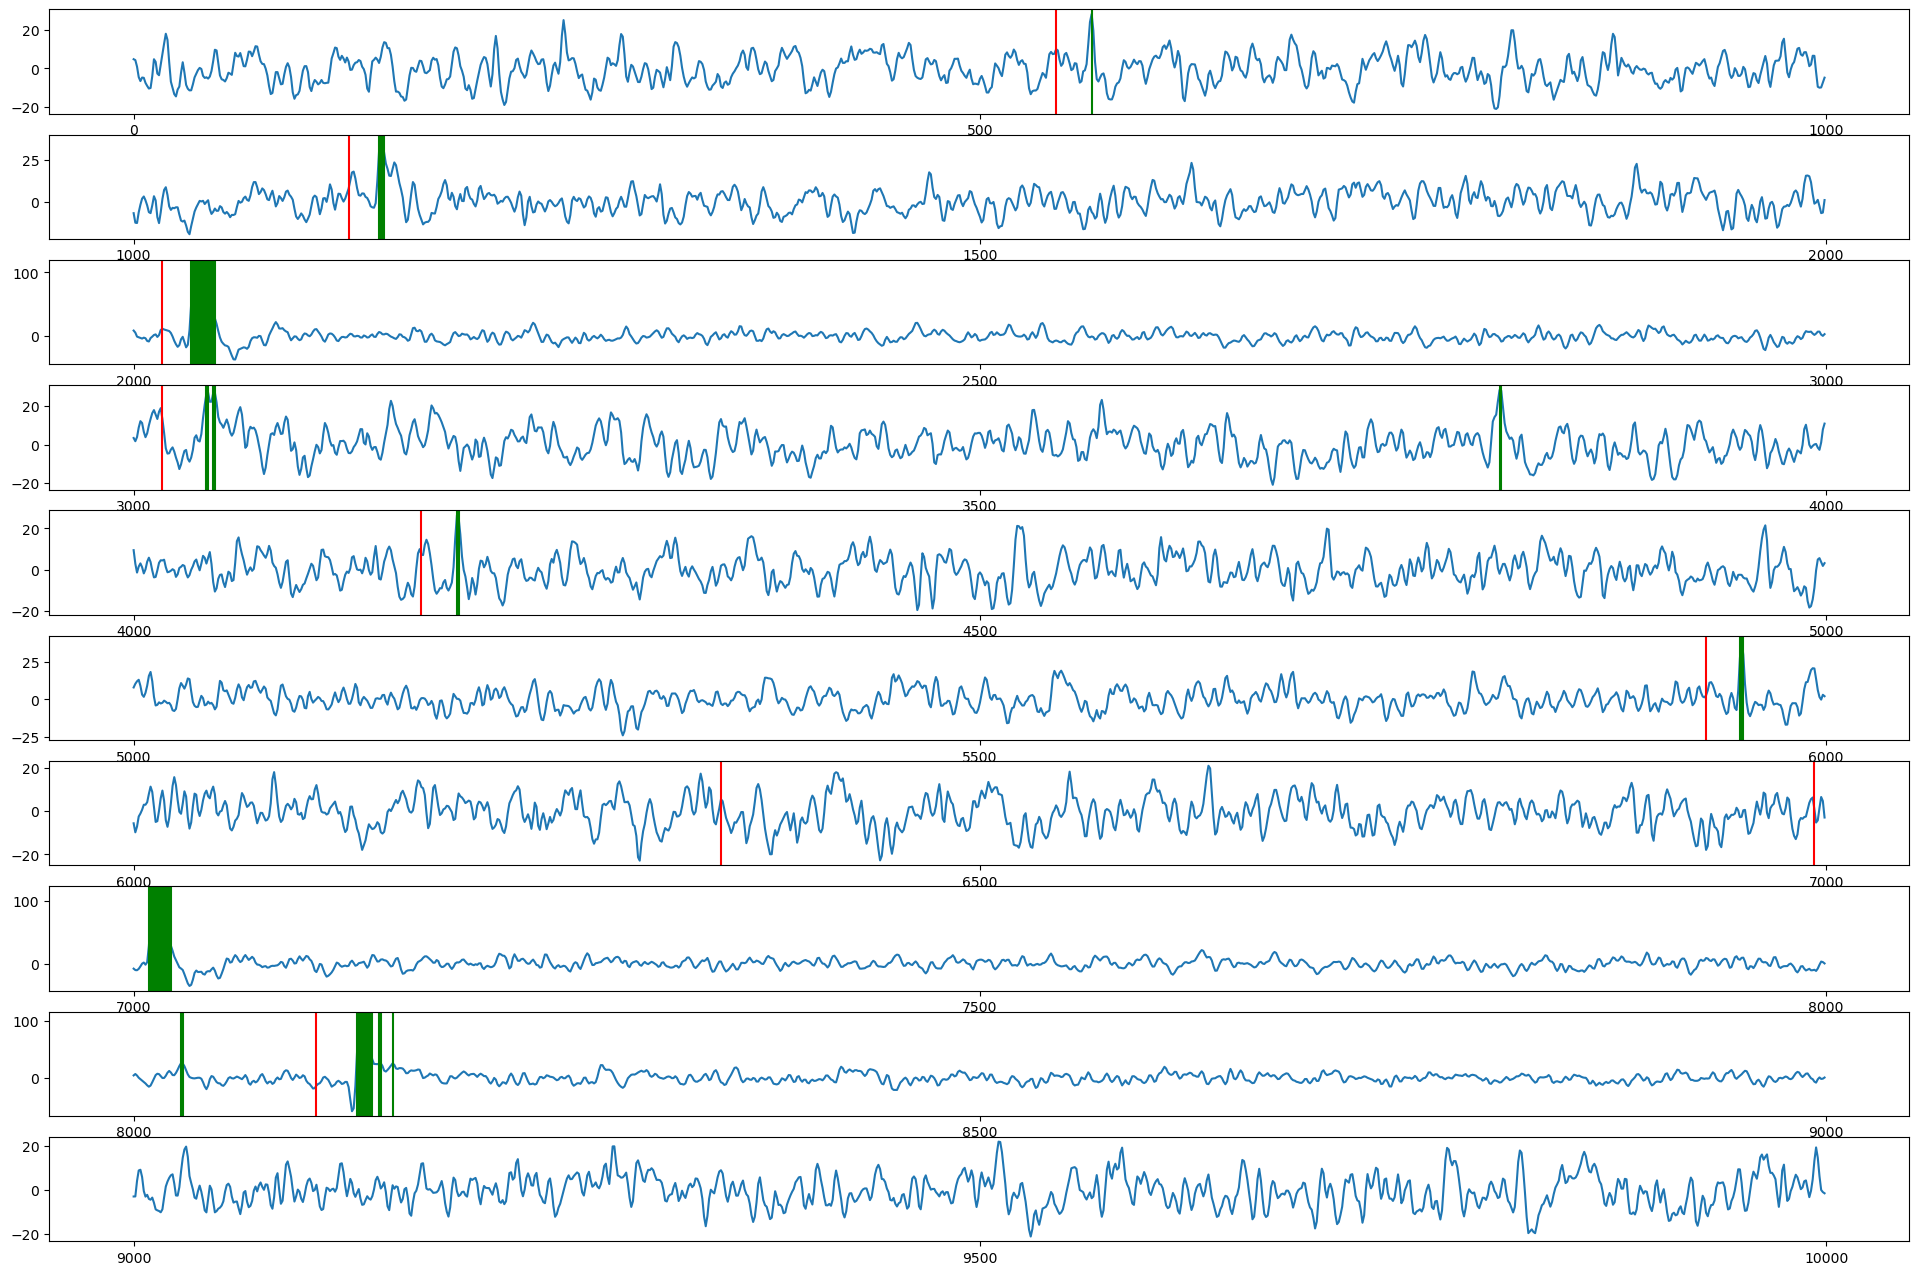

In [52]:
data = mat_file['data'][0][:10000]
spike_times = mat_file['spike_times'][0][0][0]

SUBPLOT_SIZE = 1000
N_SUBPLOTS = data.shape[0]//SUBPLOT_SIZE

fig, ax = plt.subplots(nrows=N_SUBPLOTS, ncols=1, figsize=(24,16))

for i in range(0, N_SUBPLOTS):
    start = i*SUBPLOT_SIZE
    end = (i+1)*SUBPLOT_SIZE
    
    ax[i].plot(data[start:end])
    ax[i].set_xticks([0, SUBPLOT_SIZE // 2, SUBPLOT_SIZE])
    ax[i].set_xticklabels([start, (start + end) // 2, end])
    
    # TODO: Clean up, first solution should work but doesnt. Need to get rid of the loops
    # ax[i].axvline(spike_times[np.where(i*SUBPLOT_SIZE<spike_times<i*SUBPLOT_SIZE+SUBPLOT_SIZE-1)], color='red', label="ground truth")    
    # ax[i].axvline(detected_spikes[np.where(i*SUBPLOT_SIZE<spike_times<i*SUBPLOT_SIZE+SUBPLOT_SIZE-1)], color='green', label="detected")
    
    
    for j, detected in enumerate(detected_spikes):
        if start < detected <= end:
            ax[i].axvline(detected-start, color='green', label="detected")
                
    for j, truth in enumerate(spike_times):
        if start < truth <= end:
            ax[i].axvline(truth-start, color='red', label="ground truth")
            
plt.show() 

We can again observe the offset between the true spike times and the local maxima. Our code detects the maxima. 

We can also see that there are some false positive detections in the first 10000 data points. 

Next steps are to use the Z-score for a more accurate comparison and finetune the threshhold. 


## Optimize the Treshold
1) Regarding the f1 score

In [53]:
# data
data = mat_file['data'][0]
spike_times = mat_file['spike_times'][0][0][0]


# mean and stdv
mean = np.mean(data, axis=0)
std_dev = np.std(data, axis=0)

# params
threshold_param = np.arange(0, 25, 0.1)
thresholds = mean + threshold_param * std_dev

best_threshold = 0
best_f1 = 0
best_prediction = None

for threshold in thresholds:
    pred = detect_spikes(data, threshold)
    fn, fp, tp = fast_count_fp_fn_tp(spike_times, pred)
    
    f1 = calc_F1_score(tp, fp, fn)
    precision = calc_precision(tp, fp)
    recall = calc_recall(tp, fn)
    
    print(f'LOG ===  Threshold: {threshold}, F1: {f1}, false positives: {fn}, false negatives: {fp}, true positives: {tp} == precision: {precision}, recall: {recall}')
    
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold
        best_prediction = pred
        
        
        
        
print(f'Best Threshold: {best_threshold}, Best F1: {best_f1}')
print(f'fn, fp, tp: {fast_count_fp_fn_tp(spike_times, best_prediction)}')
print(f'Best Prediction: {best_prediction}')

LOG ===  Threshold: 0.4507385876702088, F1: 0.004681173351976463, false positives: 1366732, false negatives: 0, true positives: 3214 == precision: 1.0, recall: 0.0023460778746023565
LOG ===  Threshold: 1.3583684690724778, F1: 0.005226122482164272, false positives: 1223547, false negatives: 0, true positives: 3214 == precision: 1.0, recall: 0.0026199072190915755
LOG ===  Threshold: 2.2659983504747467, F1: 0.005890692284641037, false positives: 1084785, false negatives: 0, true positives: 3214 == precision: 1.0, recall: 0.002954046832763633
LOG ===  Threshold: 3.1736282318770157, F1: 0.006709062766475977, false positives: 951679, false negatives: 0, true positives: 3214 == precision: 1.0, recall: 0.0033658221392344483
LOG ===  Threshold: 4.081258113279285, F1: 0.007717835548148823, false positives: 826448, false negatives: 0, true positives: 3214 == precision: 1.0, recall: 0.0038738667071650866
LOG ===  Threshold: 4.988887994681553, F1: 0.008958560386661946, false positives: 711098, fals


Best Threshold: 102.10528530472433, Best F1: 0.3712323540633346 \
fn, fp, tp: (1055, 2241, 973) \
Best Prediction: [   2036    2037    7011 ... 2869560 2870495 2870496]



2) Regarding precision

In [54]:
# data
data = mat_file['data'][0]
spike_times = mat_file['spike_times'][0][0][0]


# mean and stdv
mean = np.mean(data, axis=0)
std_dev = np.std(data, axis=0)

# params
threshold_param = np.arange(0, 25, 0.1)
thresholds = mean + threshold_param * std_dev

best_threshold = 0
best_precision = 0
best_prediction = None

for threshold in thresholds:
    pred = detect_spikes(data, threshold)
    fn, fp, tp = fast_count_fp_fn_tp(spike_times, pred)
    
    f1 = calc_F1_score(tp, fp, fn)
    precision = calc_precision(tp, fp)
    recall = calc_recall(tp, fn)
    
    print(f'LOG ===  Threshold: {threshold}, F1: {f1}, false positives: {fn}, false negatives: {fp}, true positives: {tp} == precision: {precision}, recall: {recall}')
    
    if precision > best_precision:
        best_precision = precision
        best_threshold = threshold
        best_prediction = pred
        
        
        
        
print(f'Best Threshold: {best_threshold}, Best precision: {best_precision}')
print(f'fn, fp, tp: {fast_count_fp_fn_tp(spike_times, best_prediction)}')
print(f'Best Prediction: {best_prediction}')

LOG ===  Threshold: 0.4507385876702088, F1: 0.004681173351976463, false positives: 1366732, false negatives: 0, true positives: 3214 == precision: 1.0, recall: 0.0023460778746023565
LOG ===  Threshold: 1.3583684690724778, F1: 0.005226122482164272, false positives: 1223547, false negatives: 0, true positives: 3214 == precision: 1.0, recall: 0.0026199072190915755
LOG ===  Threshold: 2.2659983504747467, F1: 0.005890692284641037, false positives: 1084785, false negatives: 0, true positives: 3214 == precision: 1.0, recall: 0.002954046832763633
LOG ===  Threshold: 3.1736282318770157, F1: 0.006709062766475977, false positives: 951679, false negatives: 0, true positives: 3214 == precision: 1.0, recall: 0.0033658221392344483
LOG ===  Threshold: 4.081258113279285, F1: 0.007717835548148823, false positives: 826448, false negatives: 0, true positives: 3214 == precision: 1.0, recall: 0.0038738667071650866
LOG ===  Threshold: 4.988887994681553, F1: 0.008958560386661946, false positives: 711098, fals

## With Z-Score

In [55]:
data = mat_file['data'][0]

threshold = mean + 1 * std_dev

detected_spikes = []

for i in range(data.shape[0]-1):
    zscore_i = (data[i] - mean) / std_dev
    zscore_iplus1 = (data[i + 1] + mean) / std_dev
    if zscore_i < threshold and zscore_iplus1 >= threshold:
        detected_spikes.append(i)

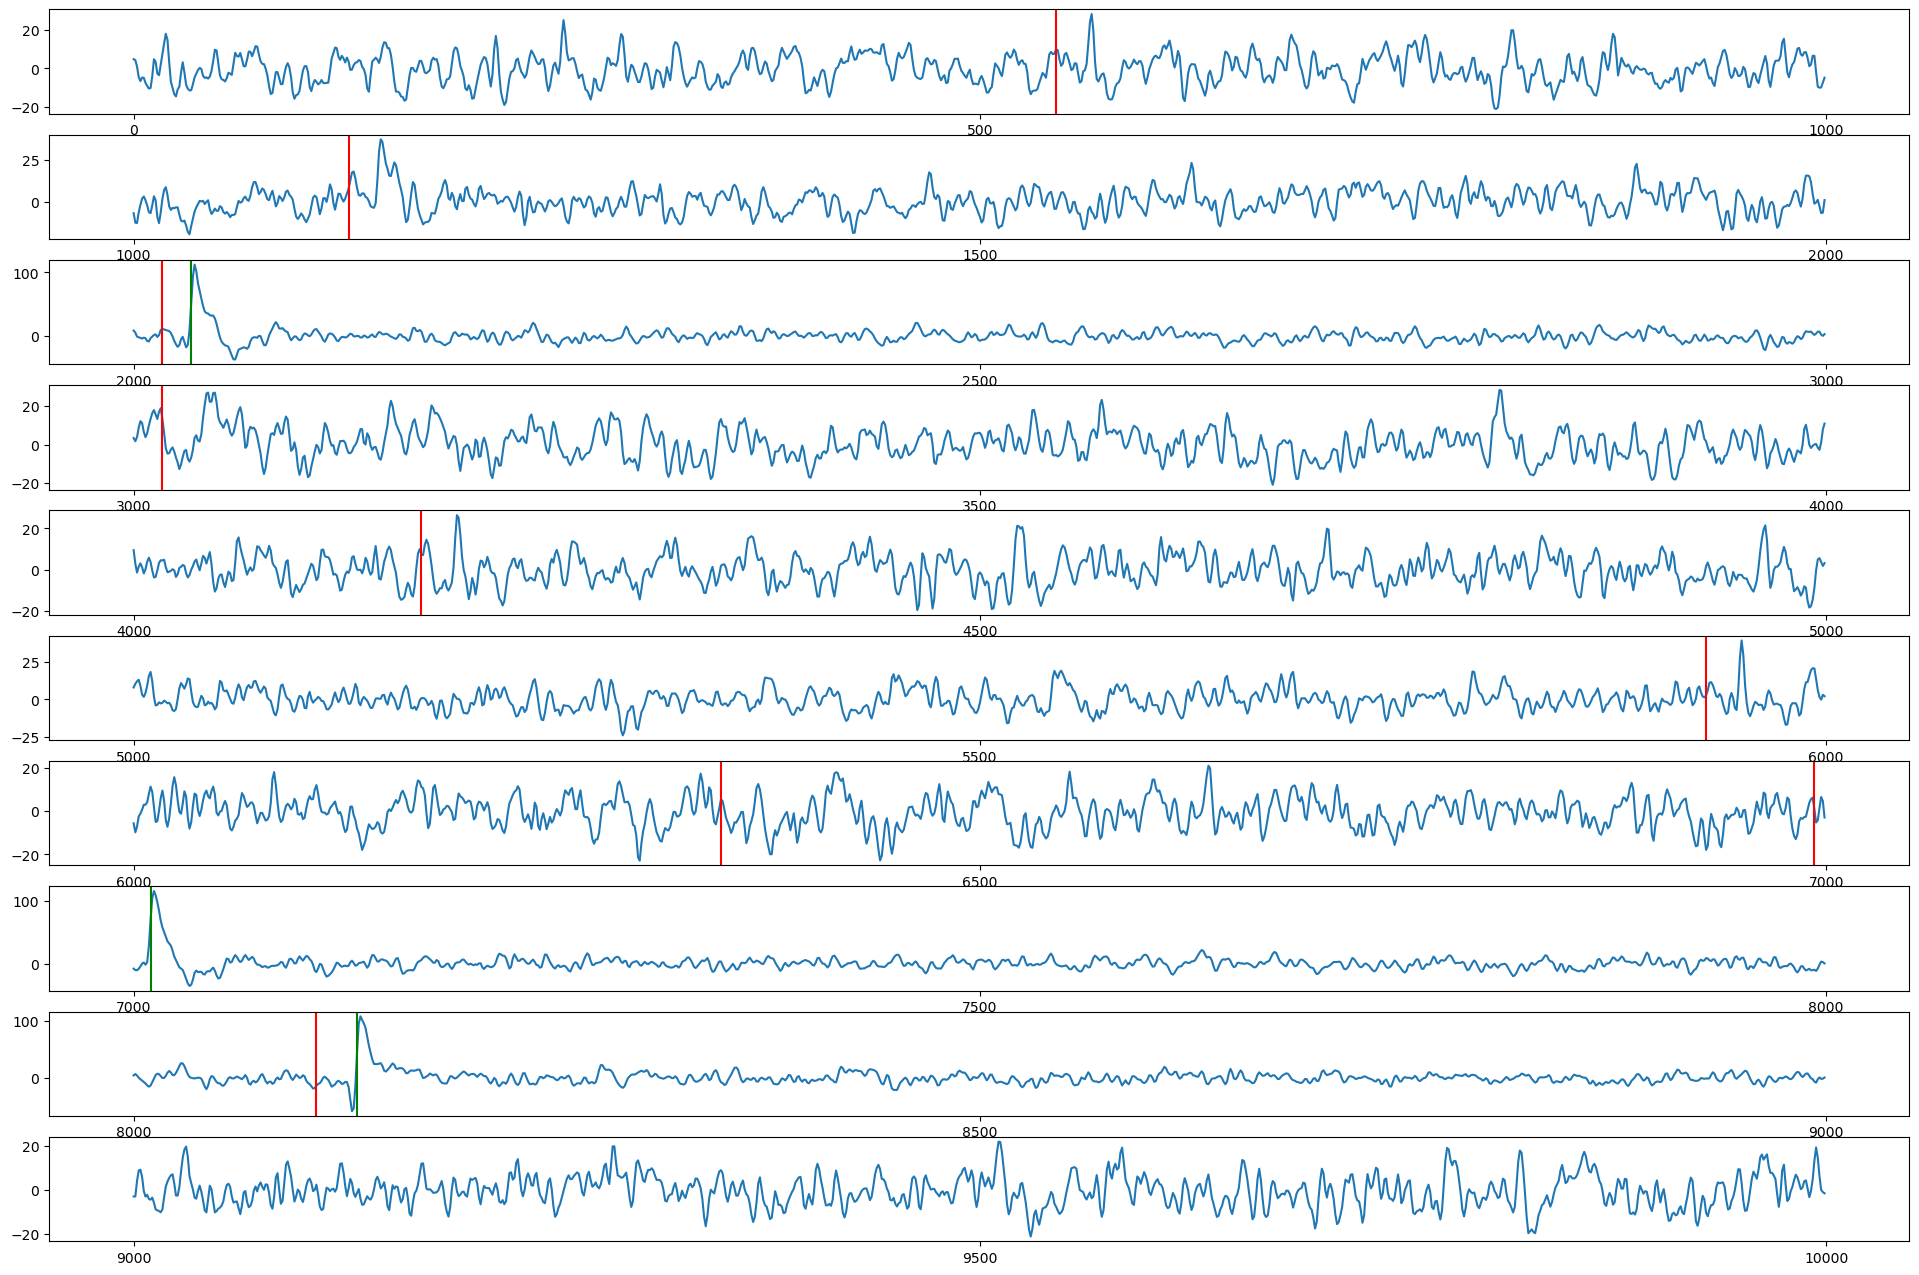

In [56]:
data = mat_file['data'][0][:10000]
spike_times = mat_file['spike_times'][0][0][0]

SUBPLOT_SIZE = 1000
N_SUBPLOTS = data.shape[0]//SUBPLOT_SIZE

fig, ax = plt.subplots(nrows=N_SUBPLOTS, ncols=1, figsize=(24,16))

for i in range(0, N_SUBPLOTS):
    start = i*SUBPLOT_SIZE
    end = (i+1)*SUBPLOT_SIZE
    
    ax[i].plot(data[start:end])
    ax[i].set_xticks([0, SUBPLOT_SIZE // 2, SUBPLOT_SIZE])
    ax[i].set_xticklabels([start, (start + end) // 2, end])
    
    # TODO: Clean up, first solution should work but doesnt. Need to get rid of the loops
    # ax[i].axvline(spike_times[np.where(i*SUBPLOT_SIZE<spike_times<i*SUBPLOT_SIZE+SUBPLOT_SIZE-1)], color='red', label="ground truth")    
    # ax[i].axvline(detected_spikes[np.where(i*SUBPLOT_SIZE<spike_times<i*SUBPLOT_SIZE+SUBPLOT_SIZE-1)], color='green', label="detected")
    
    
    for j, detected in enumerate(detected_spikes):
        if start < detected <= end:
            ax[i].axvline(detected-start, color='green', label="detected")
                
    for j, truth in enumerate(spike_times):
        if start < truth <= end:
            ax[i].axvline(truth-start, color='red', label="ground truth")
            
plt.show() 

## Without Z-Score and Average over a Several Points

In [57]:
# TODO

# Trainable Parameters

- Threshold
- Group Average

## Threshold
If we set the threshold higher we will increase the number of false negative predictions. In other words, we will 

## Sliding Window (Average of group of points)


TODO

Features:


# Principal Component Analysis



In [58]:
data = mat_file['data'][0]


## Extract the spikes

In [74]:
# TODO: Exchange this with optimal method (Local Outlier Factor)
# params
threshold_param = 2.7
left_interval = 30
right_interval = 20

# data
data = mat_file['data'][0]
spike_times = mat_file['spike_times'][0][0][0]


# mean and stdv
mean = np.mean(data, axis=0)
std_dev = np.std(data, axis=0)


threshold = mean + threshold_param * std_dev

def detect_spikes(data, threshold):
    return np.where((data > threshold).astype(int) == 1)[0]

detected_spike_times = detect_spikes(data, threshold)

detected_spikes = []

for t in detected_spike_times:
    spike = data[t-left_interval:t+right_interval]
    detected_spikes.append(spike)
    


KeyboardInterrupt: 

## PCA

Covariance 

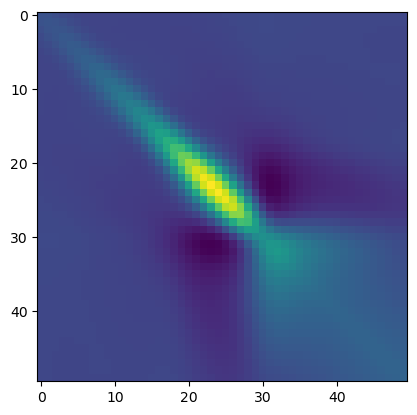

In [60]:
covariance = np.cov(detected_spikes, rowvar=False)

fig, ax = plt.subplots(nrows=1, ncols=1)
ax.imshow(covariance)

[1.17242515e+04 6.76466156e+03 4.13380712e+03 3.27560040e+03
 2.39802684e+03 1.79462321e+03 1.51815159e+03 1.11745350e+03
 7.77354342e+02 5.63383716e+02 3.96773266e+02 2.84147672e+02
 2.17075721e+02 1.64522297e+02 1.19965468e+02 9.86158037e+01
 7.75501661e+01 6.39312493e+01 5.25175716e+01 4.16970992e+01
 3.30889965e+01 2.49699139e+01 1.97614334e+01 1.47131254e+01
 1.03880717e+01 7.92577733e+00 6.15750733e+00 4.67928821e+00
 3.59833931e+00 2.67586095e+00 2.08486264e+00 1.66705637e+00
 1.25974959e+00 9.84319499e-01 7.89160044e-01 6.03982219e-01
 4.83871179e-01 3.91278680e-01 2.96860508e-01 2.31506263e-01
 1.93399151e-01 1.53655607e-01 1.23837845e-01 1.03233877e-01
 8.50719968e-02 6.99055297e-02 5.88928672e-02 4.95353703e-02
 4.62091341e-02 4.40060146e-02]


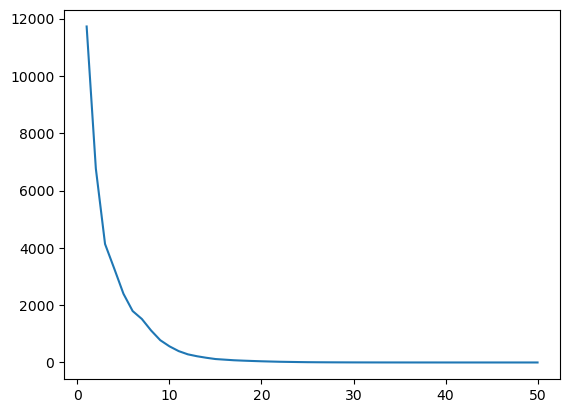

In [61]:


eigenvalues, eigenvectors = np.linalg.eig(covariance)
eigenvalues = np.sort(eigenvalues)[::-1]
print(eigenvalues)

plt.plot(np.linspace(1, len(eigenvalues), num=len(eigenvalues)), eigenvalues)

plt.show()

In [64]:
total_variance_kept = eigenvalues[0:10].sum()
total_variance = eigenvalues.sum()

ratio_kept = total_variance_kept / total_variance

print(f'Variance kept: {total_variance_kept}, total variance: {total_variance}, ratio kept: {ratio_kept}')

Variance kept: 34067.31381093526, total variance: 35721.78883330958, ratio kept: 0.9536844296881467


In [73]:
pca = PCA(n_components=10)
X = pca.fit_transform(detected_spikes)

print("Stop")

Stop


# Clustering

In [75]:
clusters = DBSCAN(eps=0.1, min_samples=2).fit(X)

cluster_labels = clusters.labels_

# TODO: Visualize output
# TODO: Compare classes to groundtruth

print("Stop")

KeyboardInterrupt: 